# Autoencoder and Dimension Reduction (1/2)

## References: 


### http://ufldl.stanford.edu/tutorial/unsupervised/Autoencoders/ (brief introduction)
### https://www.deeplearningbook.org/ (Chapter 13 and 14)
### ftp://statgen.ncsu.edu/pub/thorne/molevoclass/AtchleyOct19.pdf (PCA)
### https://www.qplum.co/documents/quant_to_AI_in_trading

## Objective

* Try to reconstruct the input by going through a small set of parameters (nodes). 
* Why? It is a way to filter out noise and keep only meaningful information from the data
* E.g. PCA (Principal Component Analysis) is probably the most well-known technique. A linear autoencoder can be mimic PCA in principle but a general (nonlinear) autoencoder can go beyond PCA. 
* An autoencoder with enough complexity can reconstruct any training data (shouldn't be doing this!) 

### Principal Component Analysis (PCA)
* Reduces feature space that explains the most of the variabilities of data
* Find linear (orthogonal) representation of features that gives the best approximation of the input features in the sense of spectral norm (sqrt of maximum squared eigenvalue)
* Given input feature number N, principal component number M (M $\leq$ N), PCA is a projection onto a M-dimensional plane embeded in N-dimensional space
* Data compression method - interpretation of reduced dimension is not always clear
* Mathematically, it is equivalent to perform singular value decomposition (any linear algebra package can handle it) - essential technique used in matrix product state (MPS)

![title](pca.png)

Above image is taken from http://www.deeplearningbook.org/contents/linear_factors.html

### Autoencoder 
* Nonlinear generalization of PCA
* If single layer with linear activation function is used, it is basically PCA if squared loss minimization is used.
* If the meaningful input information has nonlinear relations, autoencoder can outperform PCA
* For an arbitrarily complicated non-linear activation function, Autoencoder can get exctly reproduce the input data (overfitting)
* Interpretation of encoding layer (dimension reduction) is not always clear, this is common for any deep learning architecture 

![title](Autoencoder636.png)

Above image is taken from http://ufldl.stanford.edu/tutorial/unsupervised/Autoencoders/

### Autoencoder is better than PCA (when and how)? 
* Autoencoder can learn nonlinear transformation through nonlinear activation function and multiple layers
* Autoencoder with multiple layers with small number of nodes can be more efficient than PCA (in general O($N^3$) computation time for PCA) 
* Each layer in autoencoder might be useful to learn different representations hidden in data
* Autoencoder lets you use pre-trained encoder 
* more at https://www.quora.com/When-should-autoencoders-be-used-instead-of-PCA-SVD-for-dimensionality-reduction

## Simple Example of autoencoder


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Make some artifical data with 10 feature of 3 classes with 3 informative feature, 3 redundant feature, and 4 random noise

In [2]:
from sklearn.datasets import make_blobs, make_classification

In [3]:
#data, label = make_blobs(n_samples=1000, n_features=3, centers=3, random_state=2)
n_features = 10
n_informative = 3
n_redundant = 3
n_classes = 3
data, label = make_classification(n_samples=1000, n_features=n_features, n_informative=n_informative, 
                                  n_redundant=n_redundant, n_classes=n_classes, n_clusters_per_class=1, 
                                  random_state=22, shuffle=True)

In [4]:
data.shape

(1000, 10)

In [5]:
# Basic preprocssing
from sklearn.preprocessing import MinMaxScaler

In [6]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [7]:
# Only for plotting reason. Not used in the actual learning
data_x = scaled_data[:, 0]
data_y = scaled_data[:, 1]
data_z = scaled_data[:, 2]

In [8]:
from mpl_toolkits.mplot3d import Axes3D

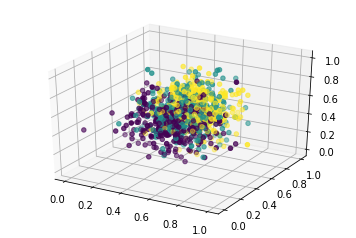

In [9]:
# See two classes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_x, data_y, data_z, c=label);

### Apply autoencoder to filter out 7 dimensions

In [11]:
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected

In [12]:
num_inputs = n_features # number of features
num_hidden = n_informative # feature reduction
num_outputs = num_inputs # reconstruct

In [13]:
learning_rate = 0.01

In [14]:
X = tf.placeholder(tf.float32, shape=[None, num_inputs])

hidden = fully_connected(X, num_hidden, activation_fn=tf.nn.elu) 
outputs = fully_connected(hidden, num_outputs, activation_fn=None)

loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

In [15]:
init = tf.global_variables_initializer()

In [16]:
# Actual training
num_steps = 10000

with tf.Session() as sess:
    sess.run(init)
    
    for iteration in range(num_steps):
        sess.run(train, feed_dict={X:scaled_data})
        
        if iteration % 1000 == 0:
            error = sess.run(loss, feed_dict={X:scaled_data})
            print('At iteration {}: mean squared error is {}'.format(iteration, error))
    
    # Record the output of hidden layer (reduced dimension)
    output_encoder = hidden.eval(feed_dict={X:scaled_data})

At iteration 0: mean squared error is 0.29825878143310547
At iteration 1000: mean squared error is 0.010119735263288021
At iteration 2000: mean squared error is 0.009823248721659184
At iteration 3000: mean squared error is 0.009777075611054897
At iteration 4000: mean squared error is 0.009774375706911087
At iteration 5000: mean squared error is 0.00977440644055605
At iteration 6000: mean squared error is 0.009774409234523773
At iteration 7000: mean squared error is 0.009775441139936447
At iteration 8000: mean squared error is 0.009774344973266125
At iteration 9000: mean squared error is 0.009782632812857628


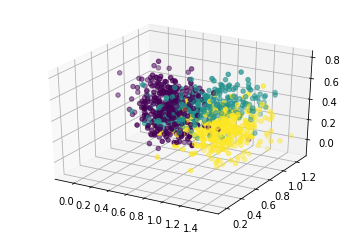

In [18]:
# See how they are separated
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(output_encoder[:, 0], output_encoder[:, 1], output_encoder[:, 2], c=label);

### Apply autoencoder to reduce feature dimension to 2

In [19]:
num_inputs = n_features # number of features
num_hidden = 2 # feature reduction
num_outputs = num_inputs # reconstruct
learning_rate = 0.001

X = tf.placeholder(tf.float32, shape=[None, num_inputs])

hidden = fully_connected(X, num_hidden, activation_fn=tf.nn.elu) 
outputs = fully_connected(hidden, num_outputs, activation_fn=None)

loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [20]:
# Actual training
num_steps = 10000

with tf.Session() as sess:
    sess.run(init)
    
    for iteration in range(num_steps):
        sess.run(train, feed_dict={X:scaled_data})
        
        if iteration % 1000 == 0:
            error = sess.run(loss, feed_dict={X:scaled_data})
            print('At iteration {}: mean squared error is {}'.format(iteration, error))
    
    # Record the output of hidden layer (reduced dimension)
    output_encoder_2d = hidden.eval(feed_dict={X:scaled_data})

At iteration 0: mean squared error is 0.22481830418109894
At iteration 1000: mean squared error is 0.020207077264785767
At iteration 2000: mean squared error is 0.016529718413949013
At iteration 3000: mean squared error is 0.01426827535033226
At iteration 4000: mean squared error is 0.013436824083328247
At iteration 5000: mean squared error is 0.013216818682849407
At iteration 6000: mean squared error is 0.013110741972923279
At iteration 7000: mean squared error is 0.013033430092036724
At iteration 8000: mean squared error is 0.012987927533686161
At iteration 9000: mean squared error is 0.012959826737642288


In [21]:
output_encoder_2d.shape

(1000, 2)

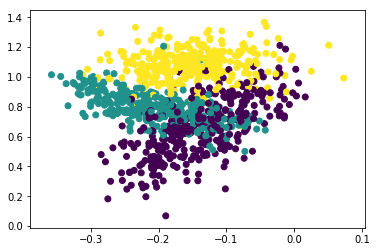

In [22]:
plt.scatter(output_encoder_2d[:, 0], output_encoder_2d[:, 1], c = label);

### Apply PCA to the same data

In [23]:
from sklearn.decomposition import PCA

In [24]:
output_pca = PCA(n_components=3).fit_transform(scaled_data)

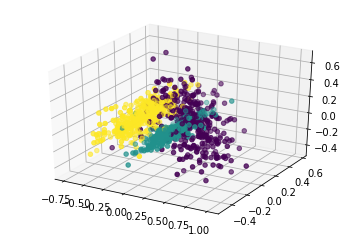

In [25]:
# See how PCA results are separated
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(output_pca[:, 0], output_pca[:, 1], output_pca[:, 2], c=label);

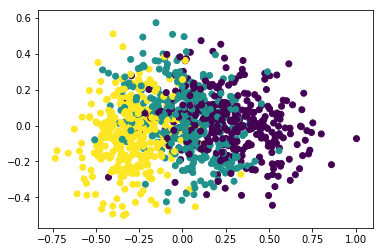

In [26]:
# See how PCA separates the data
output_pca_2d = PCA(n_components=3).fit_transform(scaled_data)
plt.scatter(output_pca_2d[:, 0], output_pca_2d[:, 1], c = label);

In [61]:
# See equivalent squared error from PCA: 
U, s, V = np.linalg.svd(scaled_data)

S = np.zeros((1000, 10))
S[:10, :10] = np.diag(s)
S[2:, 2:] = 0 # remove other singular values
error = scaled_data - np.dot(U, np.dot(S, V))
pca_error = np.mean(error*error)

In [63]:
print('auto encoder with 2 nodes has error of 0.012956')
print('PCA of 2 dimension has error of %4f' % pca_error)

auto encoder with 2 nodes has error of 0.012956
PCA of 2 dimension has error of 0.014129


## Autoencoder in real example - MNIST

In [198]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [271]:
tf.reset_default_graph() 

### number of features

In [318]:
num_inputs = 784 # 28*28
num_hidden_1 = 96
num_hidden_2 = 48
num_hidden_3 = num_hidden_1
num_outputs = num_inputs

### define graph

In [319]:
X = tf.placeholder(tf.float32, shape=[None, num_inputs])

hidden_1 = fully_connected(X, num_hidden_1, activation_fn=tf.nn.elu, 
                           weights_initializer=tf.variance_scaling_initializer, 
                           biases_initializer=tf.zeros_initializer)
hidden_2 = fully_connected(hidden_1, num_hidden_2, activation_fn=tf.nn.elu,
                           weights_initializer=tf.variance_scaling_initializer, 
                           biases_initializer=tf.zeros_initializer)
hidden_3 = fully_connected(hidden_2, num_hidden_3, activation_fn=tf.nn.elu, 
                           weights_initializer=tf.variance_scaling_initializer, 
                           biases_initializer=tf.zeros_initializer)
outputs = fully_connected(hidden_3, num_outputs, activation_fn=None, 
                          weights_initializer=tf.variance_scaling_initializer, 
                          biases_initializer=tf.zeros_initializer)

In [320]:
loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer()
train = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [321]:
# Save tensorflow graph
saver = tf.train.Saver()

In [322]:
# Actual training
num_epochs = 9
batch_size = 150

with tf.Session() as sess:
    sess.run(init)
    
    # Epoch == Entire Training Set
    for epoch in range(num_epochs):
        
        num_batches = mnist.train.num_examples // batch_size
        
        # 150 batch size
        for iteration in range(num_batches):
            
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(train, feed_dict={X: X_batch})
            
        training_loss = loss.eval(feed_dict={X: X_batch})   
        
        print("Epoch {} Complete. Training Loss: {}".format(epoch,training_loss))
     
    saver.save(sess, "./autoencoder_mnist")    

Epoch 0 Complete. Training Loss: 0.01797117292881012
Epoch 1 Complete. Training Loss: 0.014382469467818737
Epoch 2 Complete. Training Loss: 0.01364972349256277
Epoch 3 Complete. Training Loss: 0.012519290670752525
Epoch 4 Complete. Training Loss: 0.011821652762591839
Epoch 5 Complete. Training Loss: 0.012113832868635654
Epoch 6 Complete. Training Loss: 0.01244664378464222
Epoch 7 Complete. Training Loss: 0.012194438837468624
Epoch 8 Complete. Training Loss: 0.012220473960042


In [323]:
# Restore graph
with tf.Session() as sess:
    
    saver.restore(sess,"./autoencoder_mnist")
    
    results = outputs.eval(feed_dict={X:mnist.test.images[:num_test_images]})
    
    # Later usage
    train_auto = outputs.eval(feed_dict={X:mnist.train.images})
    test_auto = outputs.eval(feed_dict={X:mnist.test.images})

INFO:tensorflow:Restoring parameters from ./autoencoder_mnist


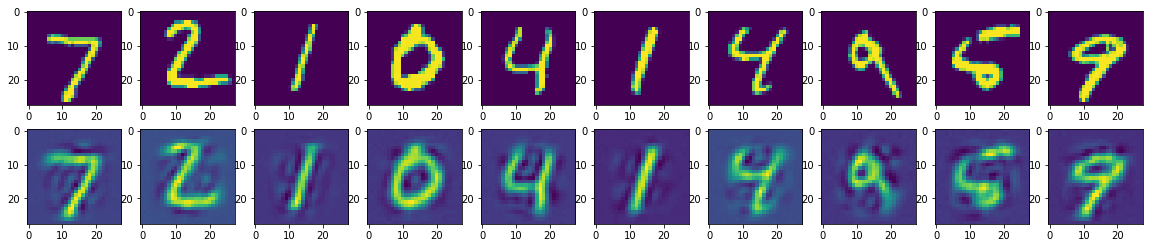

In [324]:
# Compare original images with their reconstructions
num_test_images = 10

f, a = plt.subplots(2, 10, figsize=(20, 4))
for i in range(num_test_images):
    a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
    a[1][i].imshow(np.reshape(results[i], (28, 28)))

## Apply PCA to MNIST data

In [290]:
train_data = mnist.train.images
test_data = mnist.test.images

In [291]:
num_pca_components = 48

In [292]:
train_pca = PCA(n_components=num_pca_components).fit(train_data) # Do PCA

test_pca = train_pca.transform(test_data) # Apply the result to test set

results_pca = train_pca.inverse_transform(test_pca)

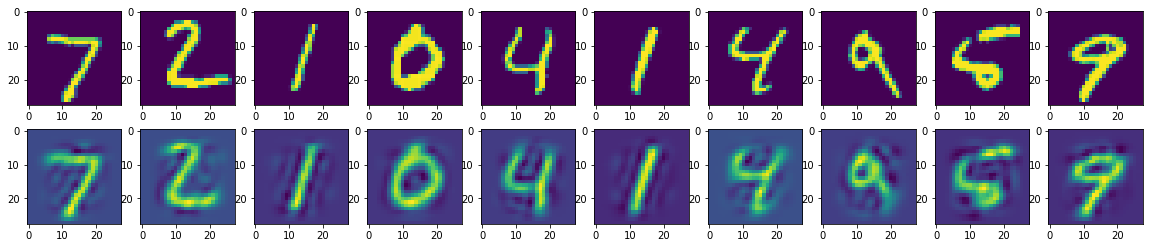

In [293]:
# Compare original images with their reconstructions
num_test_images = 10

f, a = plt.subplots(2, 10, figsize=(20, 4))
for i in range(num_test_images):
    a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
    a[1][i].imshow(np.reshape(results_pca[i], (28, 28)))

## Run classifier on the reduced output

### We will use tensorflow's estimator API 

In [294]:
tf.reset_default_graph()

In [295]:
from tensorflow import estimator

In [296]:
feat_cols = [tf.feature_column.numeric_column('x', shape=[784])]

In [297]:
deep_model = estimator.DNNClassifier(hidden_units=[16,16], 
                                    feature_columns= feat_cols, 
                                    n_classes = 10, 
                                    optimizer=tf.train.AdamOptimizer(learning_rate=0.001))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\SHELLY~1\\AppData\\Local\\Temp\\tmpykkg_91g', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000201A67AA748>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Apply DNNClassifier to bare MNIST data wihtout filtering

In [298]:
# define input - MNIST without filtering
training_input_fn = estimator.inputs.numpy_input_fn(x={'x': mnist.train.images}, 
                                                  y=mnist.train.labels.astype(np.int32), 
                                                  shuffle=True,
                                                  batch_size=150, 
                                                  num_epochs=5)

# train
deep_model.train(input_fn=training_input_fn, steps=1000)

# evaluate input
input_fn_eval = estimator.inputs.numpy_input_fn(x={'x': mnist.test.images}, shuffle=False)

# prediction
preds_mnist = list(deep_model.predict(input_fn=input_fn_eval))
predictions_mnist = [p['class_ids'][0] for p in preds_mnist]

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\SHELLY~1\AppData\Local\Temp\tmpykkg_91g\model.ckpt.
INFO:tensorflow:loss = 348.68118, step = 1
INFO:tensorflow:global_step/sec: 426.72
INFO:tensorflow:loss = 123.34375, step = 101 (0.234 sec)
INFO:tensorflow:global_step/sec: 557.04
INFO:tensorflow:loss = 56.269707, step = 201 (0.180 sec)
INFO:tensorflow:global_step/sec: 557.04
INFO:tensorflow:loss = 56.32303, step = 301 (0.180 sec)
INFO:tensorflow:global_step/sec: 553.963
INFO:tensorflow:loss = 54.874744, step = 401 (0.181 sec)
INFO:tensorflow:global_step/sec: 550.918
INFO:tensorflow:loss = 58.339558, step = 501 (0.183 sec)
INFO:tensorflow:global_step/sec: 557.042
INFO:tensorflow:loss = 48.686848, step = 601 (0.180 sec)
INFO:tensorflow:global_step/s

In [302]:
tf.reset_default_graph()

Apply DNNClassifier to PCA reduced data

In [303]:
# apply PCA transform - PCA
train_pca_data = train_pca.inverse_transform(train_pca.transform(train_data))
test_pca_data = train_pca.inverse_transform(train_pca.transform(test_data))


training_input_fn_pca = estimator.inputs.numpy_input_fn(x={'x': train_pca_data}, 
                                                      y=mnist.train.labels.astype(np.int32), 
                                                      shuffle=True,
                                                      batch_size=150, 
                                                      num_epochs=5)

# train
deep_model.train(input_fn=training_input_fn_pca, steps=1000)

# evaluate input
input_fn_eval_pca = estimator.inputs.numpy_input_fn(x={'x': test_pca_data}, shuffle=False)

# prediction
preds_pca = list(deep_model.predict(input_fn=input_fn_eval_pca))
predictions_pca = [p['class_ids'][0] for p in preds_pca]

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\SHELLY~1\AppData\Local\Temp\tmpykkg_91g\model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1001 into C:\Users\SHELLY~1\AppData\Local\Temp\tmpykkg_91g\model.ckpt.
INFO:tensorflow:loss = 41.933582, step = 1001
INFO:tensorflow:global_step/sec: 430.334
INFO:tensorflow:loss = 40.090786, step = 1101 (0.234 sec)
INFO:tensorflow:global_step/sec: 557.04
INFO:tensorflow:loss = 37.52212, step = 1201 (0.179 sec)
INFO:tensorflow:global_step/sec: 516.84
INFO:tensorflow:loss = 42.334675, step = 1301 (0.194 sec)
INFO:tensorflow:global_step/sec: 533.337
INFO:tensorflow:loss = 26.7499, step = 1401 (0.187 sec)
INFO:tensorflow:global_step/sec: 527.722
INFO:tensorflow:loss = 44.943485, step = 1501 (0.190 sec)
INFO:tenso

Apply DNNClaasifier to autoencoded data

In [325]:
tf.reset_default_graph()

In [326]:
training_input_fn_auto = estimator.inputs.numpy_input_fn(x={'x': train_auto}, 
                                                      y=mnist.train.labels.astype(np.int32), 
                                                      shuffle=True,
                                                      batch_size=150, 
                                                      num_epochs=5)

# train
deep_model.train(input_fn=training_input_fn_auto, steps=1000)

# evaluate input
input_fn_eval_auto = estimator.inputs.numpy_input_fn(x={'x': test_auto}, shuffle=False)

# prediction
preds_auto = list(deep_model.predict(input_fn=input_fn_eval_auto))
predictions_auto = [p['class_ids'][0] for p in preds_auto]

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\SHELLY~1\AppData\Local\Temp\tmpykkg_91g\model.ckpt-4000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 4001 into C:\Users\SHELLY~1\AppData\Local\Temp\tmpykkg_91g\model.ckpt.
INFO:tensorflow:loss = 33.500404, step = 4001
INFO:tensorflow:global_step/sec: 404.303
INFO:tensorflow:loss = 28.47185, step = 4101 (0.249 sec)
INFO:tensorflow:global_step/sec: 547.908
INFO:tensorflow:loss = 29.741158, step = 4201 (0.182 sec)
INFO:tensorflow:global_step/sec: 550.92
INFO:tensorflow:loss = 14.983498, step = 4301 (0.182 sec)
INFO:tensorflow:global_step/sec: 544.929
INFO:tensorflow:loss = 27.760914, step = 4401 (0.185 sec)
INFO:tensorflow:global_step/sec: 557.042
INFO:tensorflow:loss = 24.29737, step = 4501 (0.179 sec)
INFO:ten

In [299]:
from sklearn.metrics import confusion_matrix, classification_report

In [301]:
print('classifier on unfiltered data')
print(classification_report(mnist.test.labels,predictions_mnist))

classifier on unfiltered data
             precision    recall  f1-score   support

          0       0.94      0.98      0.96       980
          1       0.98      0.97      0.98      1135
          2       0.93      0.93      0.93      1032
          3       0.90      0.92      0.91      1010
          4       0.93      0.92      0.93       982
          5       0.95      0.86      0.90       892
          6       0.92      0.96      0.94       958
          7       0.93      0.92      0.93      1028
          8       0.92      0.89      0.90       974
          9       0.90      0.93      0.92      1009

avg / total       0.93      0.93      0.93     10000



In [304]:
print('classifier on PCA\'d data')
print(classification_report(mnist.test.labels,predictions_pca))

classifier on PCA'd data
             precision    recall  f1-score   support

          0       0.96      0.98      0.97       980
          1       0.98      0.98      0.98      1135
          2       0.93      0.93      0.93      1032
          3       0.93      0.92      0.93      1010
          4       0.93      0.95      0.94       982
          5       0.93      0.91      0.92       892
          6       0.92      0.96      0.94       958
          7       0.94      0.94      0.94      1028
          8       0.93      0.93      0.93       974
          9       0.94      0.92      0.93      1009

avg / total       0.94      0.94      0.94     10000



In [327]:
print('classifier on autoencoded data')
print(classification_report(mnist.test.labels,predictions_auto))

classifier on autoencoded data
             precision    recall  f1-score   support

          0       0.96      0.98      0.97       980
          1       0.97      0.99      0.98      1135
          2       0.95      0.93      0.94      1032
          3       0.95      0.92      0.93      1010
          4       0.93      0.97      0.95       982
          5       0.93      0.93      0.93       892
          6       0.95      0.95      0.95       958
          7       0.96      0.93      0.94      1028
          8       0.93      0.93      0.93       974
          9       0.93      0.93      0.93      1009

avg / total       0.95      0.95      0.95     10000

